In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from scripts.utils import trigonometric_date_encoding

2023-12-07 21:33:58.619925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read in the CSV data
df = pd.read_csv('/Users/nicolacecere/GitHub/UPM-Master/Stock_Market_TS_Prediction/data/sp500/csv/AAPL.csv')

In [3]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps - 1):
        end = i + n_steps
        seq_x, seq_y = data.iloc[i:end,:].values, data.iloc[end]["Close"]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df = df.drop(columns=["Adjusted Close"])

In [5]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [6]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)
train = train.drop(["Date"], axis=1)
val = val.drop(["Date"], axis=1)
test = test.drop(["Date"], axis=1)

/Users/nicolacecere/GitHub/UPM-Master/Stock_Market_TS_Prediction/models/scripts/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/nicolacecere/GitHub/UPM-Master/Stock_Market_TS_Prediction/models/scripts/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/nicolacecere/GitHub/UPM-Master/Stock_Market_TS_Prediction/models/scripts/utils.py:43: SettingWithCopyWarning:

In [7]:
# Select all columns except 'Close'
excluded_columns = ["sin_date", "cos_date"]
features_to_standardize = [column for column in train.columns if column not in excluded_columns]


# Calculate the mean and standard deviation only for the required columns
train_mean = train[features_to_standardize].mean()
train_std = train[features_to_standardize].std()

# Standardize only the required columns in the train, validation, and test sets
train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

In [8]:
features_to_standardize

['Low', 'Open', 'Volume', 'High', 'Close', 'Year', 'Month', 'Day']

In [9]:
X_train, y_train = create_sequences(train, 5)
X_val, y_val = create_sequences(val, 5)
X_test, y_test = create_sequences(test, 5)

In [10]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8466, 5, 10), (8466,), (1053, 5, 10), (1053,), (1053, 5, 10), (1053,))

In [11]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='relu')(input_layer)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (5, n_features)
input_shape = (X_train.shape[1], X_train.shape[2])  
output_units = 1

# Build and compile the model
model = build_simple_LSTM_regressor(input_shape, output_units)
model.summary()


# Train the model
history = model.fit(
x=X_train,
y=y_train,
batch_size=16,
validation_data=(X_val, y_val),
epochs=50,
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
]
).history


Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 10)]           0         
                                                                 
 lstm (LSTM)                 (None, 16)                1728      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1745 (6.82 KB)
Trainable params: 1745 (6.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
530/530 [==============================] - 3s 3ms/step - loss: 0.0185 - mae: 0.0751 - val_loss: 0.5312 - val_mae: 0.5917 - lr: 0.0010
Epoch 2/50
530/530 [==============================] - 1s 2ms/step - loss: 0.0021 - mae: 0.0287 - val_loss: 0.1034 - val_mae: 0.2286 

In [12]:

test_loss = model.evaluate(X_test, y_test, verbose=1)


33/33 [==============================] - 0s 1ms/step - loss: 1.0194 - mae: 0.8158


33/33 [==============================] - 0s 1ms/step


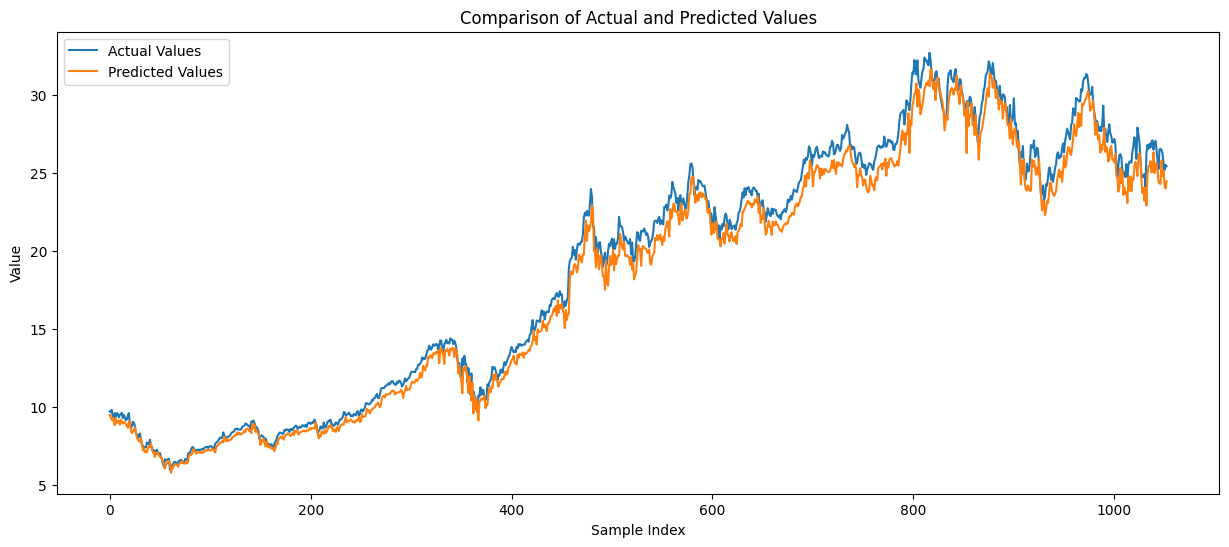

In [13]:
y_pred = model.predict(X_test)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

33/33 [==============================] - 0s 2ms/step


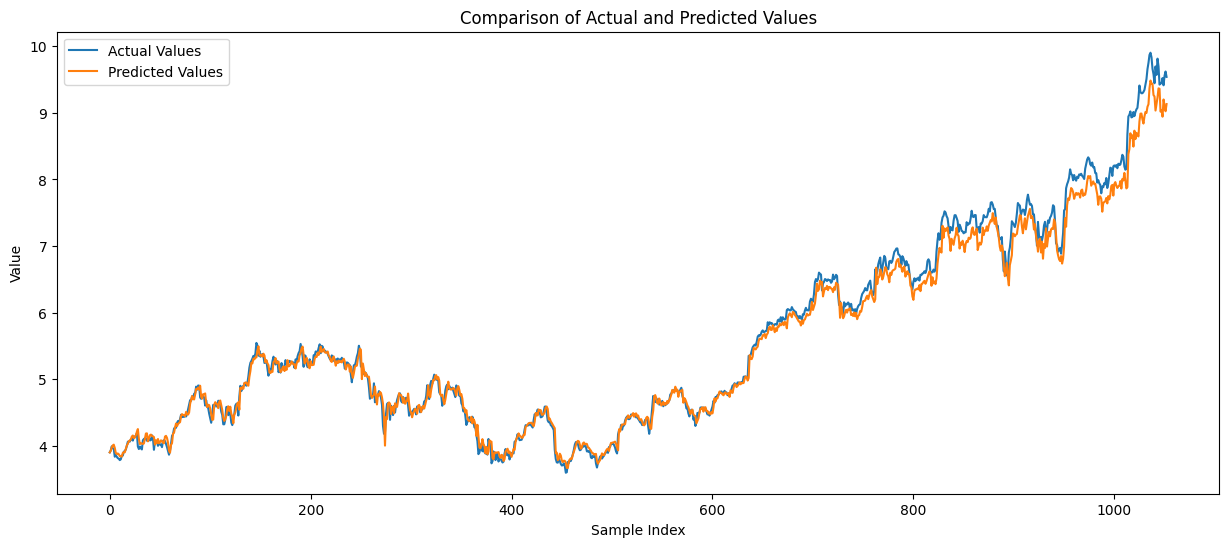

In [14]:
y_pred = model.predict(X_val)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

265/265 [==============================] - 0s 1ms/step


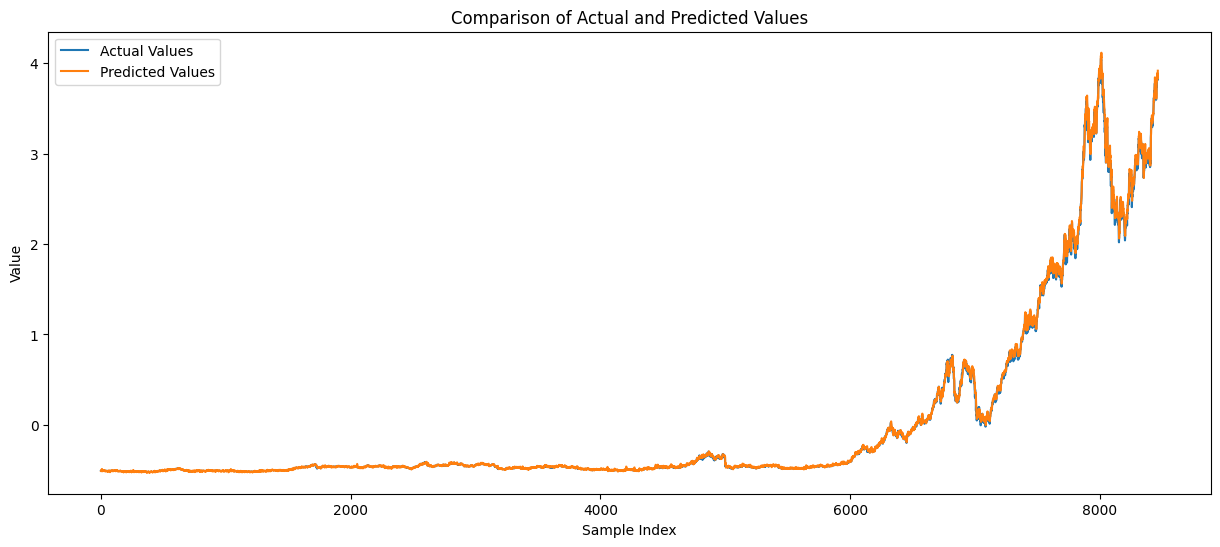

In [15]:
y_pred = model.predict(X_train)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()